# Fine-Tune a SciBERT Model
### Load queried data

In [208]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

In [209]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4
EPOCHS = 2
LEARNING_RATE = 1e-5
RANDOM_SEED = 42
MODEL_NAME = "allenai/scibert_scivocab_uncased"
CLASSES = ["human", "veterinary"]
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [210]:
from xml.etree.ElementTree import ElementTree
import pandas as pd


# Extract data from XML and create a DataFrame
xml_files = ["NEJM_data.xml", "animals_data.xml"]
data_path = "../data-querying/results/"

data_sets = [[], []]

tree = ElementTree()

hum_xml = tree.parse(data_path + xml_files[0])
hum_records = hum_xml.findall('.//Rec')

vet_xml = tree.parse(data_path + xml_files[1])
vet_records = vet_xml.findall('.//Rec')

record_sets = [hum_records, vet_records]

progress_bar = tqdm(range(len(hum_records + vet_records)))

for i, med_field in enumerate(CLASSES):
    print(f"Processing {xml_files[i]}")
    labels = [1,0] if med_field == "human" else [0,1]
    for rec in record_sets[i]:
        try: 
            common = rec.find('.//Common')
            pmid = common.find('PMID').text
            text_types = [elem.text for elem in common.findall('Type')]
            title = common.find('Title').text
            abstract = common.find('Abstract').text
            mesh_term_list = rec.find('.//MeshTermList')
            mesh_terms = [term.text for term in mesh_term_list.findall('MeshTerm')]
        except Exception as e:
            print(f"An error occurred: {e}")
            print(f"Error occured for PMID: {pmid}")

        data_sets[i].append({'pmid': pmid, "text_types": text_types, 'title': title,
                    'abstract': abstract, 'meshtermlist': mesh_terms, 'labels': labels})
        progress_bar.update(1)

hum_df = pd.DataFrame(data_sets[0])
vet_df = pd.DataFrame(data_sets[1])

 48%|████▊     | 12972/26780 [00:00<00:00, 62187.94it/s]

Processing NEJM_data.xml
Processing animals_data.xml


 95%|█████████▍| 25324/26780 [00:00<00:00, 57714.27it/s]

In [211]:
hum_df.describe()

,pmid,text_types,title,abstract,meshtermlist,labels
count,11555,11555,11555,11555,11555,11555
unique,11555,616,11544,11552,11520,1
top,616,[Journal Article],Hormone receptors in breast cancer and respons...,An 89-year-old male nursing home resident with...,[],"[1, 0]"
freq,1,1435,3,2,28,11555


In [212]:
vet_df.describe()

,pmid,text_types,title,abstract,meshtermlist,labels
count,15225,15225,15225,15225,15225,15225
unique,15225,11,15224,15194,1,1
top,25126422,[Journal Article],Tail Docking of Piglets 2: Effects of Meloxica...,In the original publication [...].,[],"[0, 1]"
freq,1,13513,2,8,15225,15225


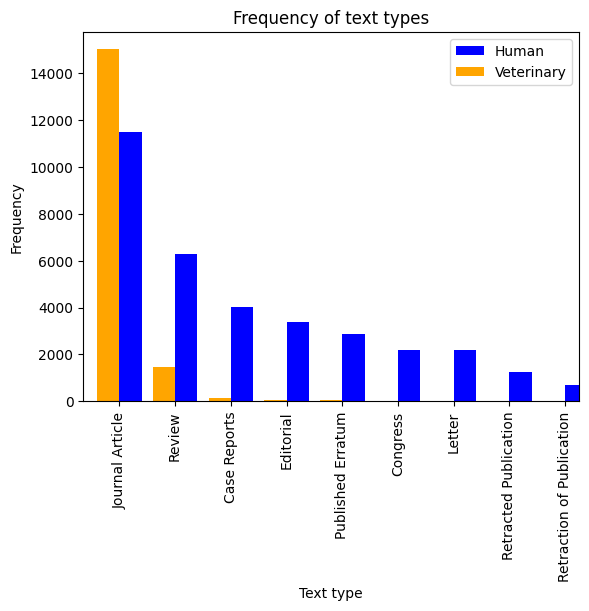

In [213]:
hum_exploded_df = hum_df.explode("text_types")
vet_exploded_df = vet_df.explode("text_types")

hum_text_type_counts = hum_exploded_df['text_types'].value_counts()
vet_text_type_counts = vet_exploded_df['text_types'].value_counts()

fig, ax = plt.subplots()

hum_text_type_counts.plot(kind='bar', position=0, width=0.4, color='blue', label='Human', ax=ax)
vet_text_type_counts.plot(kind='bar', position=1, width=0.4, color='orange', label='Veterinary', ax=ax)

plt.title('Frequency of text types')
plt.xlabel('Text type')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [214]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [215]:
class Dataset(Dataset):

    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        text = str(self.texts[idx])
        labels = self.labels[idx]

        encodings = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            pad_to_max_length=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors="pt"
        )
        
        ids = encodings['input_ids'].flatten()
        mask = encodings['attention_mask'].flatten()
        token_type_ids = encodings["token_type_ids"].flatten()


        return {
            'text': text,
            'input_ids': ids.to(device),
            'attention_mask': mask.to(device),
            'token_type_ids': token_type_ids.to(device),
            'labels': torch.tensor(labels, dtype=torch.long).to(device)
        }

In [216]:
num_objects = 100
hum_df = hum_df.sample(num_objects, random_state=42).reset_index(drop=True, inplace=False)
vet_df = vet_df.sample(num_objects, random_state=42).reset_index(drop=True, inplace=False)

In [217]:
from sklearn.model_selection import train_test_split


hum_train_set, hum_test_set = train_test_split(
  hum_df,
  test_size=0.1,
  random_state=RANDOM_SEED
)

hum_train_set, hum_val_set = train_test_split(
  hum_train_set,
  test_size=0.2,
  random_state=RANDOM_SEED
)

vet_train_set, vet_test_set = train_test_split(
  vet_df,
  test_size=0.1,
  random_state=RANDOM_SEED
)

vet_train_set, vet_val_set = train_test_split(
  vet_train_set,
  test_size=0.2,
  random_state=RANDOM_SEED
)

train_set = pd.concat([hum_train_set, vet_train_set]).sample(frac=1).reset_index(drop=True, inplace=False)
val_set = pd.concat([hum_val_set, vet_val_set]).sample(frac=1).reset_index(drop=True, inplace=False)
test_set = pd.concat([hum_test_set, vet_test_set]).sample(frac=1).reset_index(drop=True, inplace=False)

print("TRAIN Dataset: {}".format(train_set.shape))
print("VAL Dataset: {}".format(val_set.shape))
print("TEST Dataset: {}".format(test_set.shape))

TRAIN Dataset: (144, 6)
VAL Dataset: (36, 6)
TEST Dataset: (20, 6)


In [218]:
train_set

,pmid,text_types,title,abstract,meshtermlist,labels
0,1320736,"[Journal Article, Research Support, U.S. Gov't...",The declining risk of post-transfusion hepatit...,The most common serious complication of blood ...,"[Alanine Transaminase, Blood Donors, Cardiac S...","[1, 0]"
1,22616830,"[Comparative Study, Journal Article, Multicent...",Drotrecogin alfa (activated) in adults with se...,There have been conflicting reports on the eff...,"[Adult, Anti-Infective Agents, Double-Blind Me...","[1, 0]"
2,34944262,[Journal Article],Effect of Breeding Heavier Romney Ewe Lambs at...,This experiment examined the effect of breedin...,[],"[0, 1]"
3,35565567,[Case Reports],Home Range and Activity Patterns of Free-Rangi...,Human activities and the available resources i...,[],"[0, 1]"
4,36290165,[Journal Article],Copy Number Variations in the MICALL2 and MOGA...,Copy number variations (CNVs) are a result of ...,[],"[0, 1]"
...,...,...,...,...,...,...
139,34066583,[Journal Article],Oryzias curvinotus in Sanya Does Not Contain t...,Hainan medaka (Oryzias curvinotus) is distribu...,[],"[0, 1]"
140,34679939,[Journal Article],Identification of microRNAs in Silver Carp (Hy...,Hypoxia is one of the serious stresses in fish...,[],"[0, 1]"
141,36139178,[Journal Article],Influence of Different Heat-Stress-Reducing Sy...,High ambient temperatures and relative humidit...,[],"[0, 1]"
142,34205240,[Journal Article],A Retrospective Analysis of Typologies of Anim...,We conducted a retrospective study of 254 susp...,[],"[0, 1]"


In [219]:
def get_dataloader(texts, targets, tokenizer, batch_size, max_len, num_workers=0):
    dataset = Dataset(texts.to_numpy(), targets, tokenizer, max_len)
    params = {
        "batch_size":batch_size,
        "num_workers":num_workers
    }
    dataloader = DataLoader(dataset, **params)
    
    return dataloader

In [220]:
train_set["title_abstract"] = train_set[["title", "abstract"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
val_set["title_abstract"] = val_set[["title", "abstract"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
test_set["title_abstract"] = test_set[["title", "abstract"]].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)

In [221]:
train_dataloader = get_dataloader(train_set.abstract, train_set.labels, tokenizer, TRAIN_BATCH_SIZE, MAX_LEN)
val_dataloader = get_dataloader(val_set.abstract, val_set.labels, tokenizer, VAL_BATCH_SIZE, MAX_LEN)
test_dataloader = get_dataloader(test_set.abstract, test_set.labels, tokenizer, TEST_BATCH_SIZE, MAX_LEN)

In [222]:
class SciBertClassifier(torch.nn.Module):

    def __init__(self, dropout=0.5):

        super(SciBertClassifier, self).__init__()

        self.scibert =AutoModel.from_pretrained(MODEL_NAME, num_labels=2)
        self.dropout = torch.nn.Dropout(dropout)
        self.linear = torch.nn.Linear(self.scibert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):

        scibert_output = self.scibert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids = token_type_ids)
        dropout_output = self.dropout(scibert_output[1])
        output = self.linear(dropout_output)

        return output

In [223]:
model = SciBertClassifier()
model = model.to(device)

In [224]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [225]:
from transformers import get_linear_schedule_with_warmup

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_dataloader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [226]:
def eval_model(model, dataloader, loss_fn, device):
    model = model.eval()
    
    loss = 0.0
    correct_predictions = 0.0
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data["input_ids"].to(device, dtype = torch.long)
            attention_mask = data["attention_mask"].to(device, dtype = torch.long)
            token_type_ids = data["token_type_ids"].to(device, dtype = torch.long)
            labels = data["labels"].to(device, dtype = torch.float)
            
            outputs = model(input_ids, attention_mask, token_type_ids)
            loss += loss_fn(outputs, labels).item()
            
            preds = torch.argmax(outputs, dim=1)
            correct_predictions += torch.sum(preds == torch.argmax(labels, dim=1)).item()
            
            
    num_data = len(dataloader) * VAL_BATCH_SIZE
    return correct_predictions / num_data, loss / num_data

In [227]:
from tqdm import tqdm

def train(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, scheduler, epochs):
    progress_bar = tqdm(range(len(train_dataloader) * epochs))
    model = model.train()
    history = []
    best_acc = 0
    
    for epoch_num in range(epochs):
        print("_" * 30)
        print(f'Epoch {epoch_num} started.')
        
        total_loss = 0
        correct_predictions = 0.0
        
        for data in train_dataloader:
            input_ids = data['input_ids'].to(device, dtype = torch.long)
            attention_mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            labels = data['labels'].to(device, dtype = torch.float)

            outputs = model(input_ids, attention_mask, token_type_ids)
            preds = torch.argmax(outputs, dim=1)
            correct_predictions += torch.sum(preds == torch.argmax(labels, dim=1)).item()
            
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            
            
            loss.backward()
            # to avoid exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
                        
            progress_bar.update(1)
        
        num_data = len(train_dataloader) * TRAIN_BATCH_SIZE
        train_acc = correct_predictions / num_data
        train_loss = total_loss / num_data
        print(f'Epoch: {epoch_num}, Train Accuracy {train_acc}, Loss:  {train_loss}')

        val_acc, val_loss = eval_model(model, val_dataloader, loss_fn, device)
        print(f'Epoch: {epoch_num}, Validation Accuracy {val_acc}, Loss:  {val_loss}')
        
        history.append({"train_acc": train_acc, "train_loss": train_loss, "val_acc": val_acc, "val_loss": val_loss})
        
        if val_acc > best_acc:
            torch.save(model.state_dict(), 'best_model.bin')
            best_acc = val_acc
            
    return history

In [228]:
torch.cuda.empty_cache()
history = train(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, scheduler, EPOCHS)

100%|██████████| 26780/26780 [00:20<00:00, 57714.27it/s]c:\Users\albbl\Documents\Studium\11_Semester\medtextclassification_repo\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


______________________________
Epoch 0 started.


Epoch: 0, Train Accuracy 0.8194444444444444, Loss:  0.13998176861140463
Epoch: 0, Validation Accuracy 0.9444444444444444, Loss:  0.11228766623470518
______________________________
Epoch 1 started.


Epoch: 1, Train Accuracy 0.9722222222222222, Loss:  0.07696021296497849
Epoch: 1, Validation Accuracy 0.9722222222222222, Loss:  0.07841648699508773


100%|██████████| 72/72 [31:44<00:00, 26.46s/it]


(0.0, 1.0)

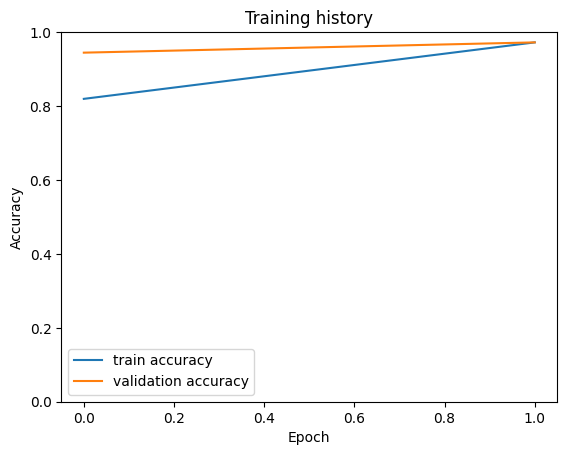

In [229]:
history = pd.DataFrame(history)

plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

In [230]:
def predict(model, texts, tokenizer, max_len=512):
    progress_bar = tqdm(range(len(texts)))

    predictions = []
    for data in texts:
        text = str(data)

        inputs = tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = torch.tensor(inputs['input_ids'], dtype=torch.long).unsqueeze(0).to(device)
        mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).unsqueeze(0).to(device)
        token_type_ids = torch.tensor(inputs["token_type_ids"], dtype=torch.long).unsqueeze(0).to(device)

        with torch.no_grad():
            logits = model(ids, mask, token_type_ids)
        
        probabilities = torch.sigmoid(logits.squeeze())
        predictions.append(probabilities)

        
        progress_bar.update(1)

    return predictions

In [231]:
acc, loss = eval_model(model, test_dataloader, loss_fn, device)
print(f"TEST dataset - Accuracy: {acc}, Loss: {loss}")

TEST dataset - Accuracy: 1.0, Loss: 0.06424072980880738


In [254]:
text = ["All animal procedures conformed with the Regulations for the Administration of Affairs Concerning Experimental Animals (Ministry of Science and Technology, Beijing, China, 2004) and were approved by the Institutional Animal Care and Use Committee (College of Animal Science and Technology, Northwest A&F University, Yanling, Xianyang, China, No. 2013-23, 20 April 2013). In this study, the 4-day-old Qinchuan beef cattle was used to isolate preadipocytes and myoblasts, and the cattle was born and raised at the breeding farm of the National Beef Cattle Improvement Center (Yangling, Xianyang, China)."]
predict(model, text, tokenizer)

c:\Users\albbl\Documents\Studium\11_Semester\medtextclassification_repo\.venv\Lib\site-packages\transformers\tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00, 17.58it/s]


[tensor([0.5312, 0.6079], device='cuda:0')]

In [233]:
test_preds = predict(model, test_set.abstract, tokenizer)
test_preds

100%|██████████| 20/20 [00:54<00:00,  2.72s/it]


[tensor([0.7572, 0.2547], device='cuda:0'),
 tensor([0.2324, 0.8524], device='cuda:0'),
 tensor([0.2101, 0.8390], device='cuda:0'),
 tensor([0.8140, 0.2052], device='cuda:0'),
 tensor([0.8088, 0.2346], device='cuda:0'),
 tensor([0.8043, 0.2538], device='cuda:0'),
 tensor([0.1739, 0.8604], device='cuda:0'),
 tensor([0.1889, 0.8545], device='cuda:0'),
 tensor([0.8050, 0.2114], device='cuda:0'),
 tensor([0.2627, 0.7806], device='cuda:0'),
 tensor([0.2371, 0.8378], device='cuda:0'),
 tensor([0.2223, 0.8175], device='cuda:0'),
 tensor([0.7299, 0.2243], device='cuda:0'),
 tensor([0.6217, 0.3354], device='cuda:0'),
 tensor([0.7612, 0.2881], device='cuda:0'),
 tensor([0.2134, 0.8509], device='cuda:0'),
 tensor([0.2459, 0.7854], device='cuda:0'),
 tensor([0.8120, 0.2114], device='cuda:0'),
 tensor([0.5527, 0.3486], device='cuda:0'),
 tensor([0.2029, 0.8648], device='cuda:0')]

In [234]:
test_labels = [labels.index(max(labels)) for labels in test_set.labels]
preds_labels = [torch.argmax(pred).item() for pred in test_preds]
test_labels

[0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1]

In [235]:
from sklearn.metrics import confusion_matrix, classification_report
classes = ["human", "veterinary"]

report = classification_report(test_labels, preds_labels, target_names=classes)
print(report)

              precision    recall  f1-score   support

       human       1.00      1.00      1.00        10
  veterinary       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



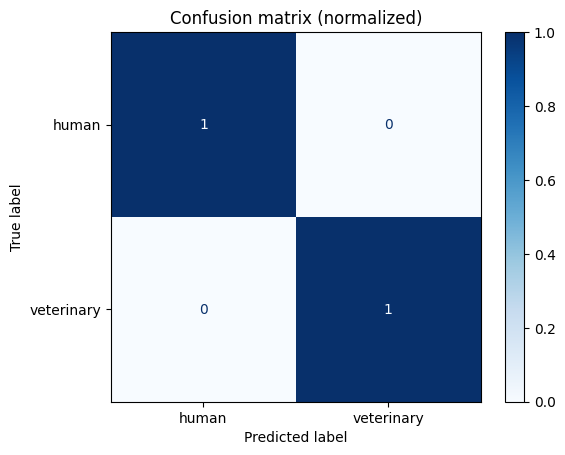

In [236]:
from sklearn.metrics import ConfusionMatrixDisplay

test_classes = ["human" if label == 0 else "veterinary" for label in test_labels]
preds_classes = ["human" if label == 0 else "veterinary" for label in preds_labels]
disp = ConfusionMatrixDisplay.from_predictions(test_classes, preds_classes, labels=classes, normalize="true", cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix (normalized)")
plt.show()